In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.metrics import classification_report

# Tensorflow
import tensorflow as tf
import tensorflow_addons as tfa

# Keras
from keras import models, layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.applications import VGG16

# Warnings
import warnings
warnings.filterwarnings("ignore")

c:\Users\faith\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\faith\anaconda3\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure yo

In [ ]:
nvidia-smi

In [ ]:
import sys
print(sys.version)


## Check GPU

In [ ]:
# Check for available physical GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # If there are GPUs available, TensorFlow should automatically utilize them
    print("Available GPU(s):")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU(s) available.")

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU(s),", len(logical_gpus), "Logical GPU(s)")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [ ]:
print(tf.config.list_physical_devices('GPU'))

### Jerick PC

# Access image directory
root_dir = r"E:/JEAN/chexscan/data"
train_dir = root_dir + "/train_data"
valid_dir = root_dir + "/test_data"

### Emman Laptop

# Access image directory
root_dir = r"E:\Jean Eileen Magtibay\chexscan\data"
train_dir = root_dir + "/train_data"
valid_dir = root_dir + "/test_data"

# Access image directory
root_dir = r"E:/Jean Eileen Magtibay/chexscan/others/dataset"
train_dir = root_dir + "/train"
valid_dir = root_dir + "/valid"

In [ ]:
# Access image directory
root_dir = r"E:/chexscan/others/dataset"
train_dir = root_dir + "/train"
valid_dir = root_dir + "/valid"

### Declaration

In [ ]:
# Acquiring a list of all class names
class_names = os.listdir(train_dir)
print(class_names)

In [ ]:
IMAGE_SIZE = 224
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 25

n_classes = len(class_names)
n_classes

## Data Generator

In [ ]:
img_size = (IMAGE_SIZE, IMAGE_SIZE)

# train_datagen = ImageDataGenerator(
#     rescale=1/255.,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.2,
#     shear_range = 0.2,
#     horizontal_flip = True,
#     rotation_range=20,
#     fill_mode='nearest',
# )

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,  # Random rotation in the range [-15, 15] degrees
    width_shift_range=0.1,  # Random horizontal shift by 10% of the width
    height_shift_range=0.1,  # Random vertical shift by 10% of the height
    brightness_range=[0.9, 1.1],  # Random brightness adjustment
    shear_range=0.2,  # Random shearing transformation
    zoom_range=0.2,  # Random zoom in the range [0.8, 1.2]
    channel_shift_range=0.05,  # Random channel shifts
    horizontal_flip=True,  # Random horizontal flipping
    fill_mode='nearest',  # Fill mode for points outside the input boundaries
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

In [ ]:
valid_datagen = ImageDataGenerator(rescale=1/255.)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical'
)

In [ ]:
# Get the class indices and names from the train generator
class_indices = train_generator.class_indices
label_to_name = {idx: name for name, idx in class_indices.items()}
samples = train_generator.__next__()  # next fetches the image from the object. Each run gives a new set of images in the training set

images = samples[0]
target = samples[1]

plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])

    # Convert the float target to integer (0 or 1)
    label_idx = tuple(target[i]).index(1)
    class_name = label_to_name[label_idx]

    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.show()

In [ ]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
# class MyCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('val_acc') > 0.99:
#             print("\nReached accuracy threshold! Terminating training.")
#             # self.model.stop_training = False

# my_callback = MyCallback()

#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold_count):
        super(MyCallback, self).__init__()
        self.threshold_count = threshold_count
        self.consecutive_count = 0

    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            self.consecutive_count += 1
            if self.consecutive_count >= self.threshold_count:
                print("\nReached accuracy threshold 3 times! Terminating training.")
                self.model.stop_training = True
        else:
            self.consecutive_count = 0

# Define the callback with the threshold count
my_callback = MyCallback(threshold_count=3)

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss",
                                 patience=10)

# EarlyStopping callback to stop training if val_loss does not improve after n epochs
earlystop_cb = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

# VGG16

In [ ]:
input_layer=layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

model_vgg16 = VGG16(weights='imagenet',
                    input_tensor=input_layer,
                    include_top=False)

last_layer=model_vgg16.output

flatten=layers.Flatten()(last_layer)

output_layer=layers.Dense(n_classes,activation='softmax')(flatten)

model_vgg16=models.Model(inputs=input_layer,outputs=output_layer)

# Making all the layers intrainable except the last layer
for layer in model_vgg16.layers[:-1]:
    layer.trainable=False

In [ ]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='acc'),
           tfa.metrics.F1Score(num_classes=n_classes)]

CALLBACKS = [my_callback, rop_callback, earlystop_cb] # Removed due to stopping condition 
# CALLBACKS = [rop_callback]


In [ ]:
model_vgg16.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
# model_vgg16.summary()

In [ ]:
history_vgg = model_vgg16.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    verbose=True,
    validation_data=valid_generator,
    callbacks=CALLBACKS,
    epochs=EPOCHS
)

              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       200
   Pneumonia       1.00      0.99      1.00       200
Tuberculosis       0.96      0.91      0.93       200

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



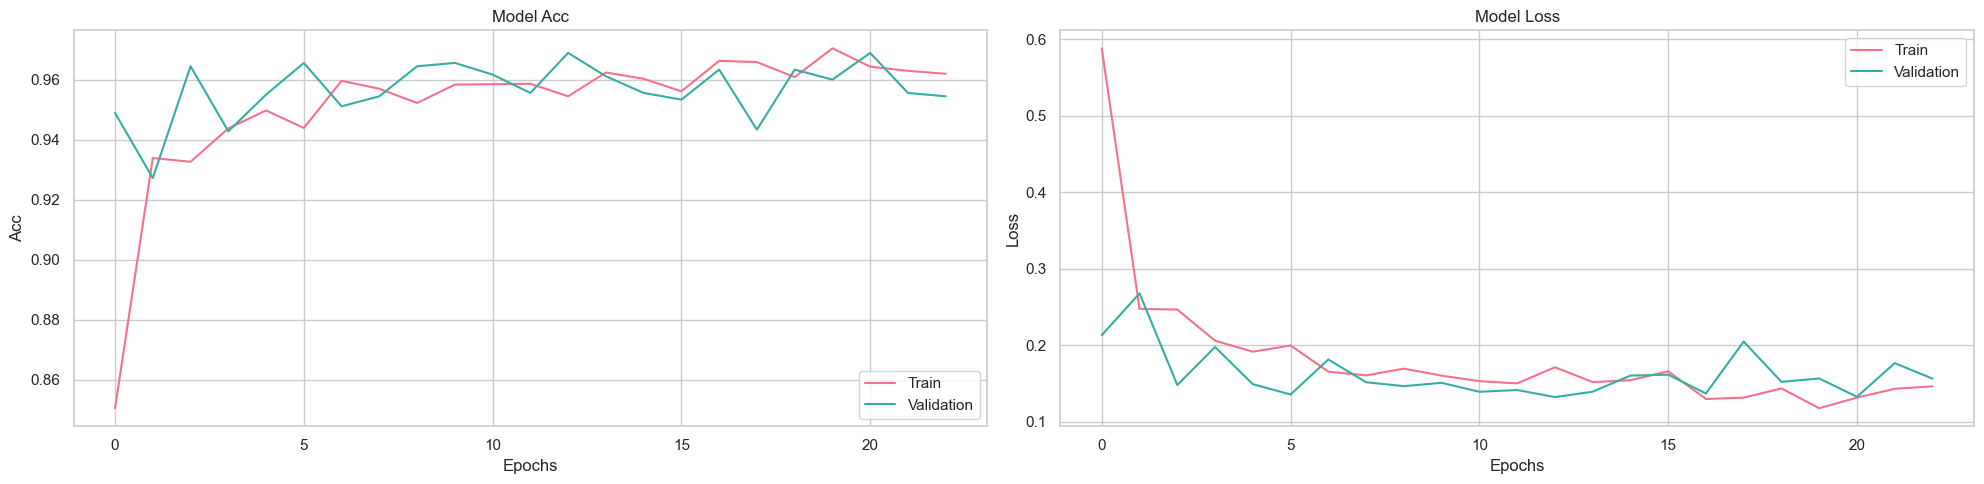

In [21]:
sns.set(style="whitegrid", rc={"axes.grid": True})

# Create a color palette
palette = sns.color_palette("husl", 2)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

# Loop through metrics
for i, metric in enumerate(["acc", "loss"]):
    sns.lineplot(x=history_vgg.epoch, y=history_vgg.history[metric], ax=ax[i], label="Train", color=palette[0])
    sns.lineplot(x=history_vgg.epoch, y=history_vgg.history["val_" + metric], ax=ax[i], label="Validation", color=palette[1])

    ax[i].set_title(f"Model {metric.capitalize()}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric.capitalize())

    ax[i].legend().set_visible(True)

plt.tight_layout()
plt.show()

In [ ]:
from PIL import Image

def predict_image(model, class_names, image_path):
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))  # Resize the image
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize the image

    # Predict the class probabilities
    prediction_probs = model.predict(img_array)

    # Round off probabilities to four decimal places
    prediction_probs = np.round(prediction_probs, 4)

    # Map the prediction probabilities to class labels
    predicted_class_index = np.argmax(prediction_probs)
    predicted_class_label = class_names[predicted_class_index]

    return predicted_class_label, prediction_probs

In [ ]:
image_path = 'E:/Jean Eileen Magtibay/chexscan/test/normal.png'
predicted_class = predict_image(model_vgg16, class_names, image_path)
predicted_class

In [ ]:
image_path = "E:/Jean Eileen Magtibay/chexscan/test/pneumonia.jpeg"
predicted_class = predict_image(model_vgg16, class_names, image_path)
predicted_class

In [ ]:
image_path = "E:/Jean Eileen Magtibay/chexscan/test/tb.png"
predicted_class = predict_image(model_vgg16, class_names, image_path)
predicted_class

In [ ]:
model_path = './chexscan'
model_json = model_vgg16.to_json()
with open(model_path, "w") as json_file:
  json_file.write(model_json)

model_vgg16.save_weights("vgg16_model.hdf5")